<a href="https://colab.research.google.com/github/possomartin/Notebooks/blob/main/Proyecto_Final_Ribadeneira_Posso_Orbe_Coloma_Berrazueta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este deber fue realizado por:
* Erik Rivadeneira
* Martin Posso
* Kevin Coloma
* Hernan Berrazueta
* Fernando Orbe

---

# Instructions
Check the following video (from minute 20:00): https://udlaec.sharepoint.com/:v:/s/Section_1073273520/EffaPi4wQO9NiIx3M8mLnqAB56XiM8gkyXgG42YkKh7LHA?e=mBTy8h

---

## Step 0

* Describe your dataset and how you built it. This was the pattern preprocessing homework.
  * Detail the process to get the dataset above.

---

## Scenarios

* In general build models from splitting the dataset columns in two:

  * First: build X with Mean, std, width, height
  * Second: build X with 28Sum_R + 28Sum_C
  * Optional Third: build X with using first and second

* Build two types of problems (models):

  * First: Classifiers. Classes are the digits digit∈{0,1,…,9}digit \in \{0,1, \dots, 9 \}digit∈{0,1,…,9}
  * Second: Regressors. Round to the nearest integer, i.e.: 8.9 would be 9, 7.2 would be 7.
  * Set limits for the regressor ouput $\hat{y} = 0 $
    * if $\hat{y} < 0 $, make $\hat{y} = 0 $
    * $\hat{y} > 9 $, make $\hat{y} = 9 $
---
## Model for each scenario

* Perform the usual steps to build a ML model.

* Select ML algorithm (from MLP, RandomForest, XGBoost, and research others, select at least 2).
* Preprocess the input accordingly.
* Build (train) the model
* Hyperparameter optimization
* Evaluate (test) the models (classification or regression)
* Cross validation
## Conclude
* Check: Determination of Moisture in Rice Grains Based on Visible Spectrum Analysis

  * https://www.mdpi.com/2073-4395/12/12/3021
  * https://www.featureranking.com/tutorials/machine-learning-tutorials/

## Check my jamboard:

* https://jamboard.google.com/d/1cVZMkqhB2pj_JceIUQD-ddXzG4d0QeX3p-sE_-JdyeI/viewer?f=18

---
# 1. ETL Dataset

## 1.1 Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from skimage .morphology import skeletonize
import matplotlib.cm as cm

## 1.2 Read Dataset

In [ ]:
mnist = pd.read_csv('https://raw.githubusercontent.com/sbussmann/kaggle-mnist/master/Data/train.csv')

## 1.3 Pattern Preprocessing

Preprocessing the MNIST dataset with min-max standardization, also known as min-max scaling, can be beneficial for fitting the data to a model for several reasons:

* Scale Invariance: Min-max standardization scales the data to a fixed range, typically between 0 and 1. This can be beneficial for some models, such as neural networks, that are scale-invariant. This means that the model's performance is not affected by the scale of the input features. So, by scaling the features to a specific range, the model can work better.

* Handling Outliers: Scaling the data can also help to handle outliers, which can have a significant impact on the model's performance. By scaling the data, outliers will be less influential on the final result.

* Speed of Convergence: Scaling the data can also help to speed up the convergence of optimization algorithms, such as gradient descent, that are used to train some models.

* Same Scale for all features: Min-max standardization scales all features to the same range, this can help to balance the importance of the features during the training process.

* In the case of MNIST, the dataset contains images of handwritten digits, which can have a range of pixel intensities. By scaling the pixel intensities to a specific range, the model can learn better patterns in the data, which can improve its performance.

Overall, preprocessing the MNIST dataset with min-max standardization can be beneficial for fitting the data to a model by handling outliers, by providing the same scale for all features, by speeding up the convergence of optimization algorithms and by providing a scale-invariant model.

In [ ]:
def normalize_data(mnist, norm_type='std'):
  df = mnist.copy()
  df = df.drop(columns=['label'])
  ''' Binarize Data, convert values greater than 0 to 1'''
  #df.loc[ df[“column_name”] == “some_value”, “column_name”] = “value”
  cols = df.columns
  for c in cols:
    df.loc[df[c] > 0, c] = 1

  if (norm_type == 'minMax'):
    # Normalization min max

    min = df.min()
    max = df.max()

    df = (df - min) / (max - min)
  else:
    #Normalization and standarization
    mean_px = df.mean().astype(np.float32)
    std_px = df.std().astype(np.float32)

    df = (df - mean_px) / (std_px)


  df.insert(0, 'label', mnist['label'])
  df = df.fillna(0)
  return df

In [ ]:
'''
  Graph Mean
'''
def graph_mean(df):
  plt.figure(figsize=(15,15))
  legend = []
  for i in range(10):
    legend.append('Digit ' + str(i))
    digit_mean = df.query('label == ' + str(i)).mean()
    sns.kdeplot(digit_mean)
    plt.legend(legend)
    plt.xlabel('Digit mean')

'''
  Graph std
'''

def graph_std(df):
  plt.figure(figsize=(15,15))
  legend = []
  for i in range(10):
    legend.append('Digit ' + str(i))
    digit_std = df.query('label == ' + str(i)).std()
    sns.kdeplot(digit_std)
    plt.legend(legend)
    plt.xlabel('Digit Standard Deviation')

'''
  Graph Moments
'''

def graph_moment(df, sample_size=100):
  plt.figure(figsize=(20,11))
  std = []
  mean = []
  digits = []
  for i in range(10):
    digit_mean = df.query('label == ' + str(i)).head(sample_size).mean(axis=1)
    digit_std = df.query('label == ' + str(i)).head(sample_size).std(axis=1)
    digits += [str(i)] * sample_size
    mean.append(digit_mean)
    std.append(digit_std)

  digit_moments = pd.DataFrame({'mean': pd.concat(mean), 'std': pd.concat(std), 'digit': digits})

  plt.subplot(1, 2, 1)
  sns.scatterplot(data=digit_moments, x="mean", y="std", hue='digit')
  plt.hlines(0.385, 0.05, 0.175, linestyles="dashed", colors='k')
  plt.vlines(0.175, 0.25, 0.385, linestyles="dashed", colors='k')
  plt.subplot(1, 2, 2)
  sns.boxplot(data=digit_moments, x="mean", y="digit")

'''
  Graph Features
'''

def graph_features(df):
  index = 0
  plt.figure(figsize=(30,20))
  for i in range(0, 30, 6):
    digit_0 = np.array(df.query('label == ' + str(index)).iloc[0][0:-1]).reshape(28,28)
    digit_1 = np.array(df.query('label == ' + str(index + 1)).iloc[1][0:-1]).reshape(28,28)
    plt.subplot(10, 3, i + 1)
    sns.heatmap(digit_0, cbar=False)
    plt.subplot(10, 3, i + 2)
    plt.plot(digit_0.sum(axis=0),':.')
    plt.ylim(0, 21)
    plt.subplot(10, 3, i + 3)
    plt.plot(digit_1.sum(axis=0),':.')
    plt.ylim(0, 21)

    plt.subplot(10, 3, i + 4)
    plt.plot(digit_0.sum(axis=1),':.')
    plt.ylim(0, 21)
    plt.subplot(10, 3, i + 5)
    plt.plot(digit_1.sum(axis=1),':.')
    plt.ylim(0, 21)
    plt.subplot(10, 3, i + 6)
    sns.heatmap(digit_1, cbar=False)

    index += 2

'''
 Append range to dataframe
'''
def get_digit_range(df, sample_size=100):
  width = []
  height = []
  std = []
  mean = []
  digits = []
  rows_cols_sum = []
  for i in range(10):
    digit_mean = df.query('label == ' + str(i)).head(sample_size).mean(axis=1)
    digit_std = df.query('label == ' + str(i)).head(sample_size).std(axis=1)
    digits += [str(i)] * sample_size
    mean.append(digit_mean)
    std.append(digit_std)

    digit = df.query('label == ' + str(i)).head(sample_size)
    d = np.array(df.query('label == ' + str(i)).iloc[0][0:-1]).reshape(28,28)
    for d0 in digit.iterrows():
        d02d = np.array(d0[1][0:-1]).reshape(28,28)

        ds = np.where(d02d.sum(axis=0))[0]
        w0 = ds[-1] - ds[0]
        width += [w0]

        ds = np.where(d02d.sum(axis=1))[0]
        h0 = ds[-1] - ds[0]
        height += [h0]

        rows_cols_sum += [np.sum(d02d)]
  return pd.DataFrame({'width': width, 'height': height, 'mean': pd.concat(mean), 'std': pd.concat(std), '28sum_R+28sum_C': rows_cols_sum, 'digit': digits})


'''
  Graph Range
'''

def graph_range(digit_range, to_graph="width"):
  plt.figure(figsize=(20,20))
  if (to_graph == "width"):
    plt.subplot(1, 2, 1)
    sns.kdeplot(data=digit_range, x="width", hue="digit")
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=digit_range, x="width", y="mean", hue='digit')
  else:
    plt.subplot(1, 2, 1)
    sns.kdeplot(data=digit_range, x="height", hue="digit")
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=digit_range, x="height", y="mean", hue='digit')

In [ ]:
def graph_digit(df, limit_size = 100, label = 0):
  sample_size = limit_size
  plt.figure(figsize=(20,20))

  digit = df.query('label == ' + str(label)).head(sample_size)
  digit = digit.drop(columns=['label'])

  for index, d in enumerate(digit.values):
    plt.subplot(10, 10, index + 1)
    sns.heatmap(d.reshape(28, 28), cbar=False, cmap=cm.gray)
    plt.axis('off')

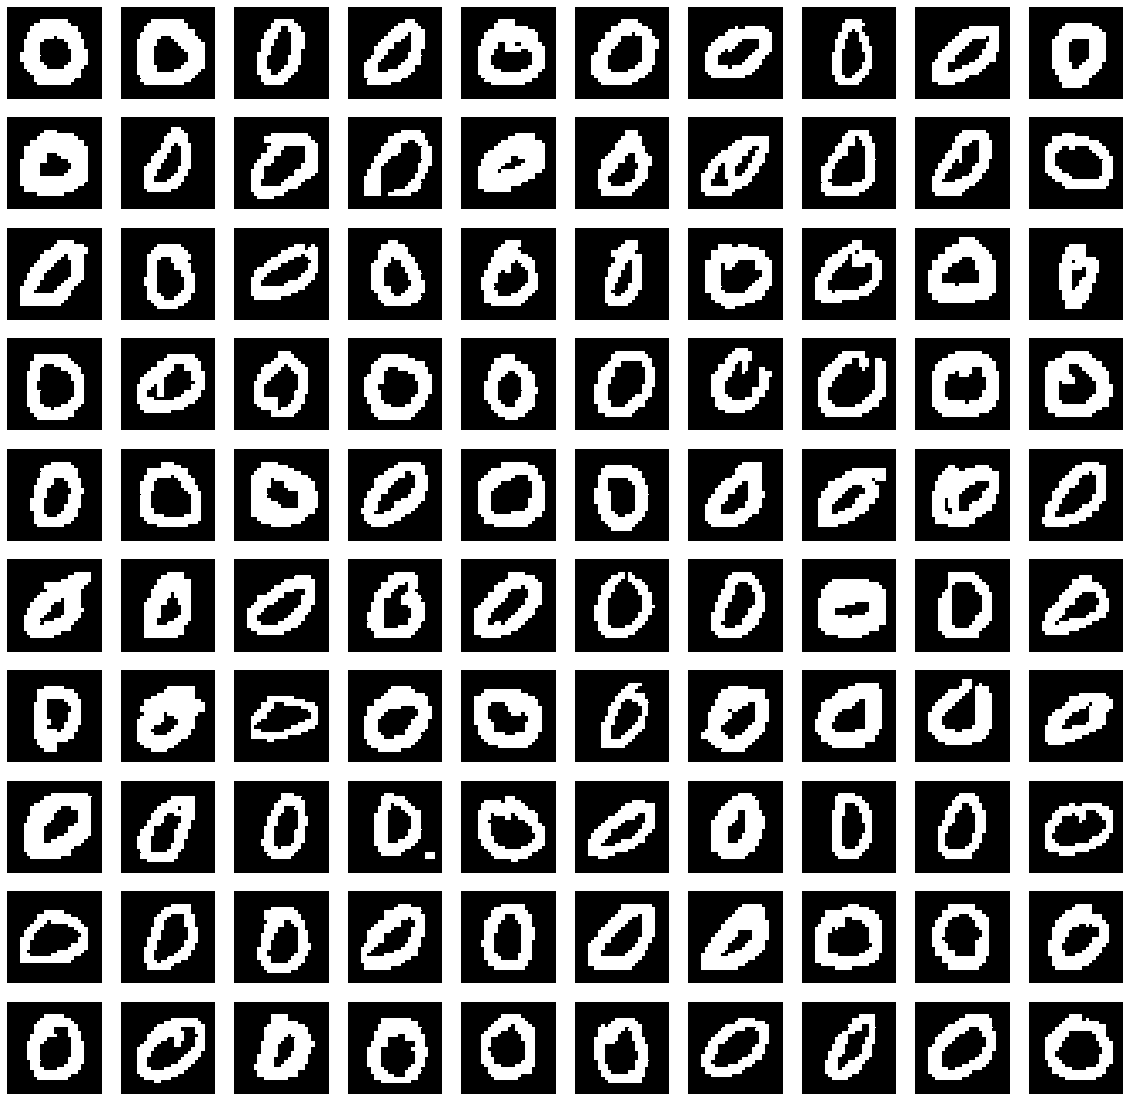

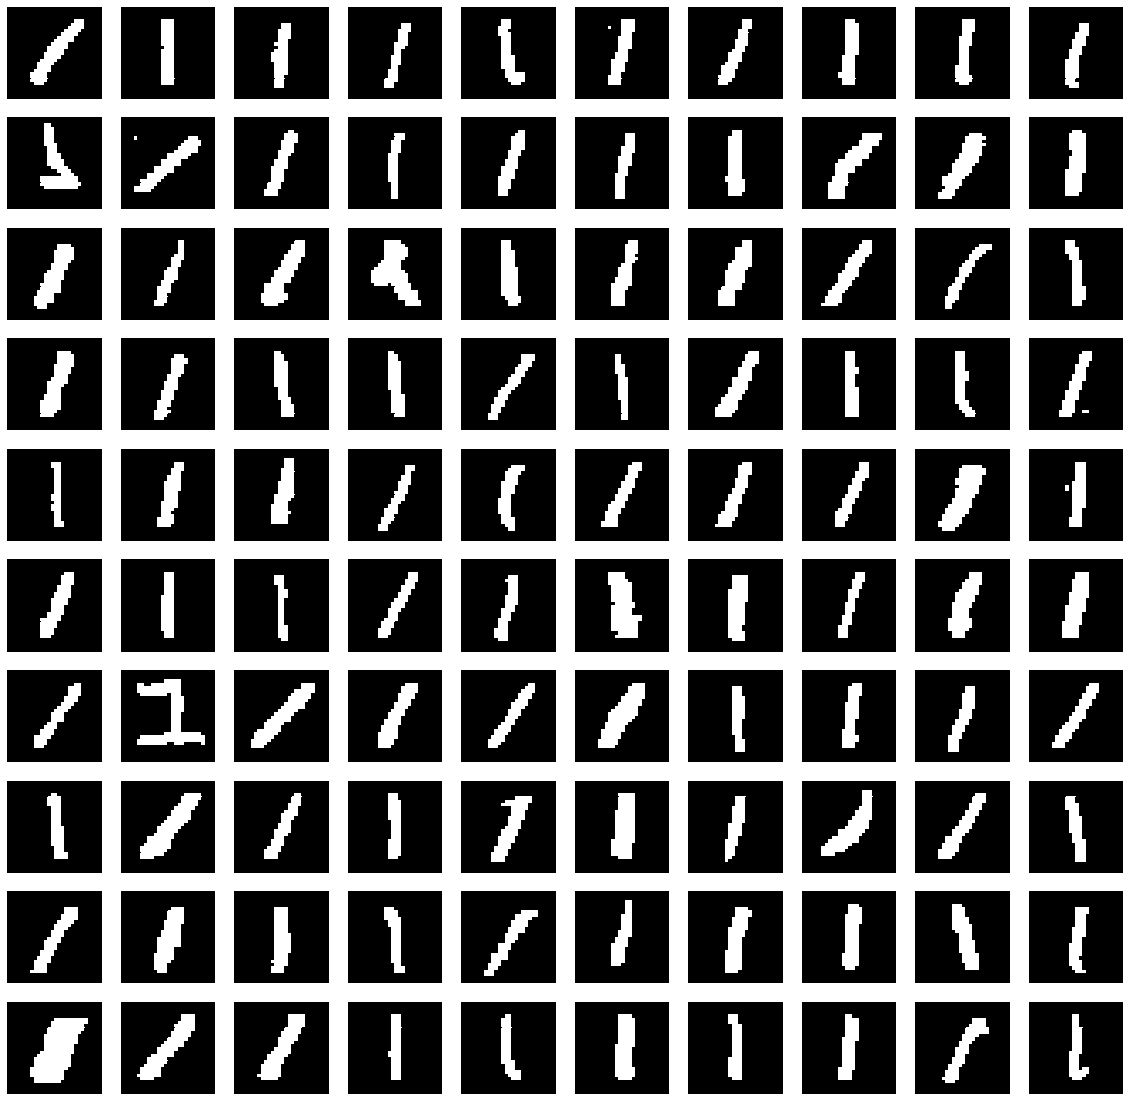

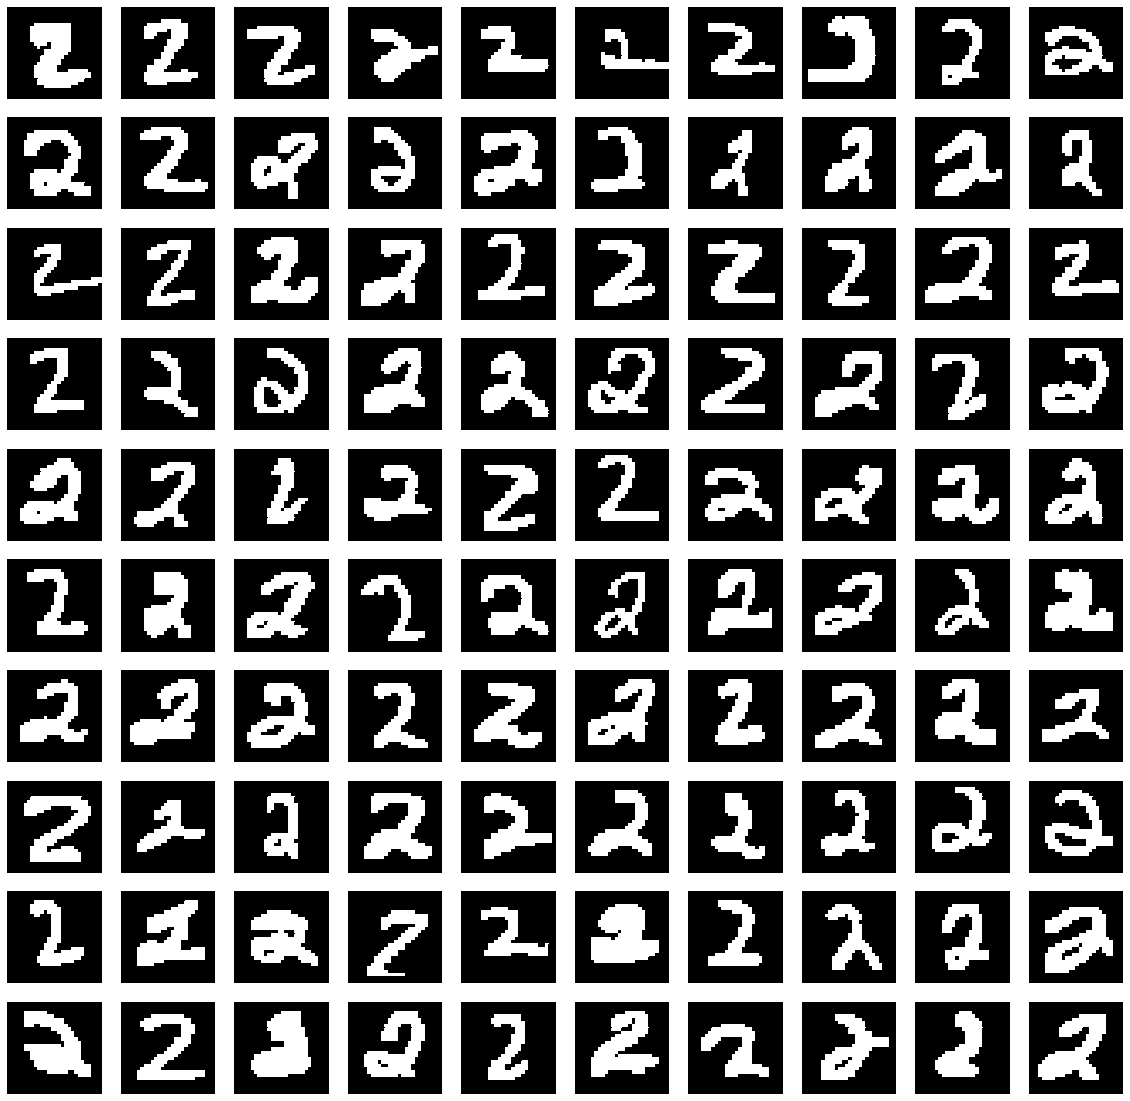

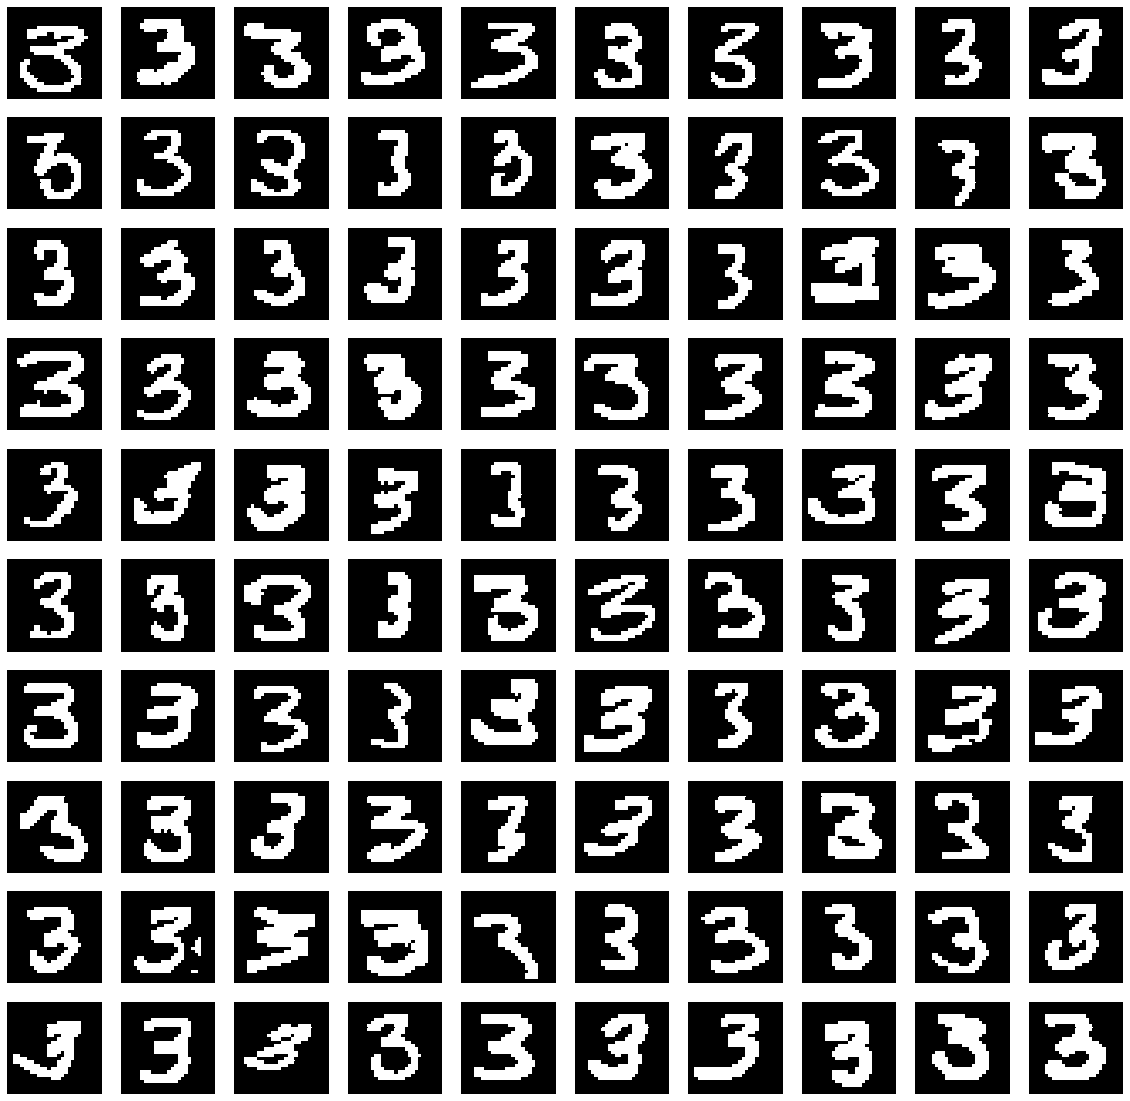

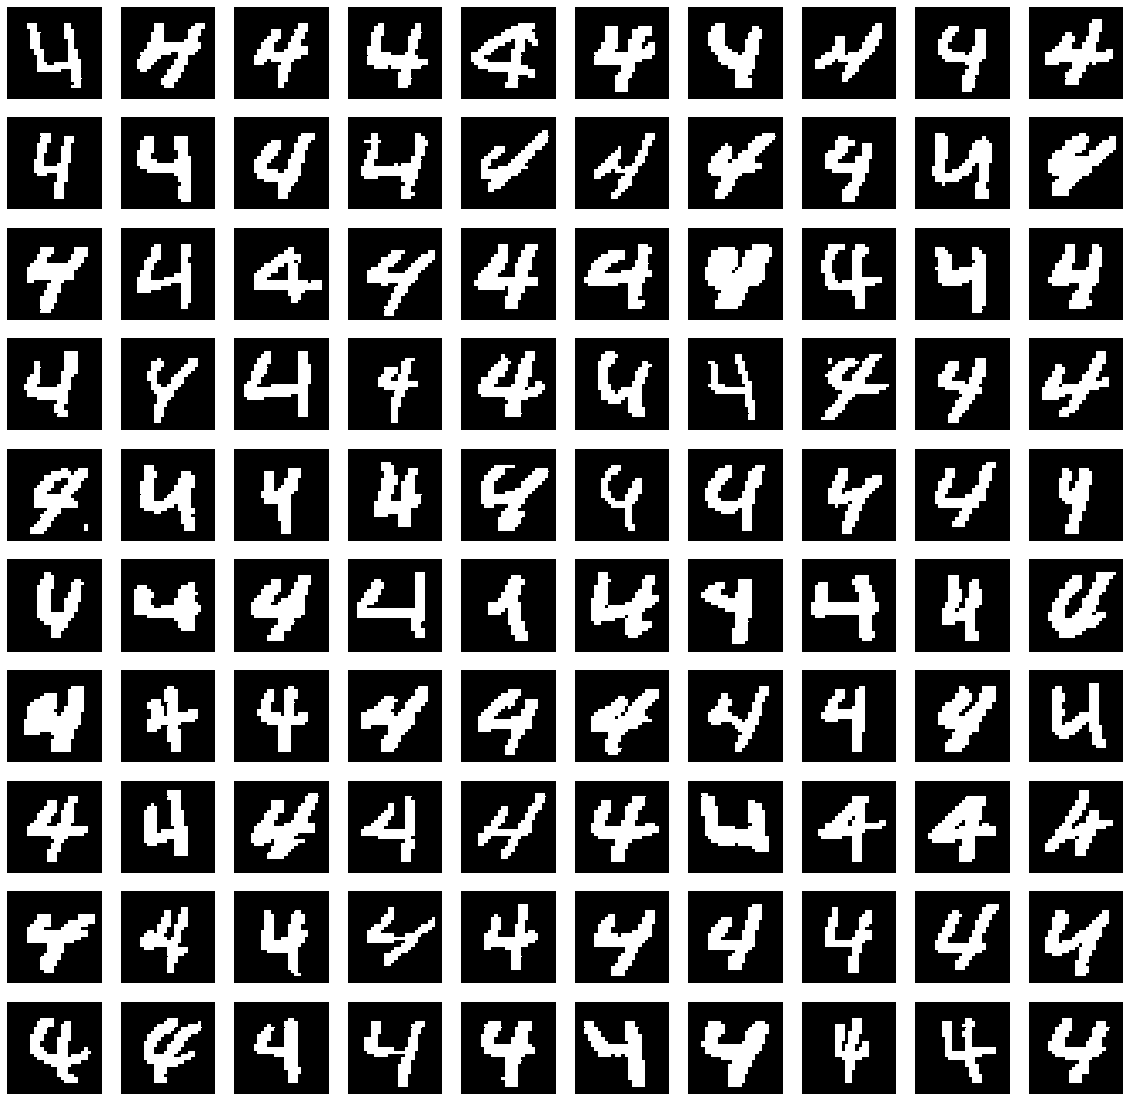

In [ ]:
df = normalize_data(mnist, norm_type='minMax')
for i in range(5):
  graph_digit(df, limit_size = 100, label=i)

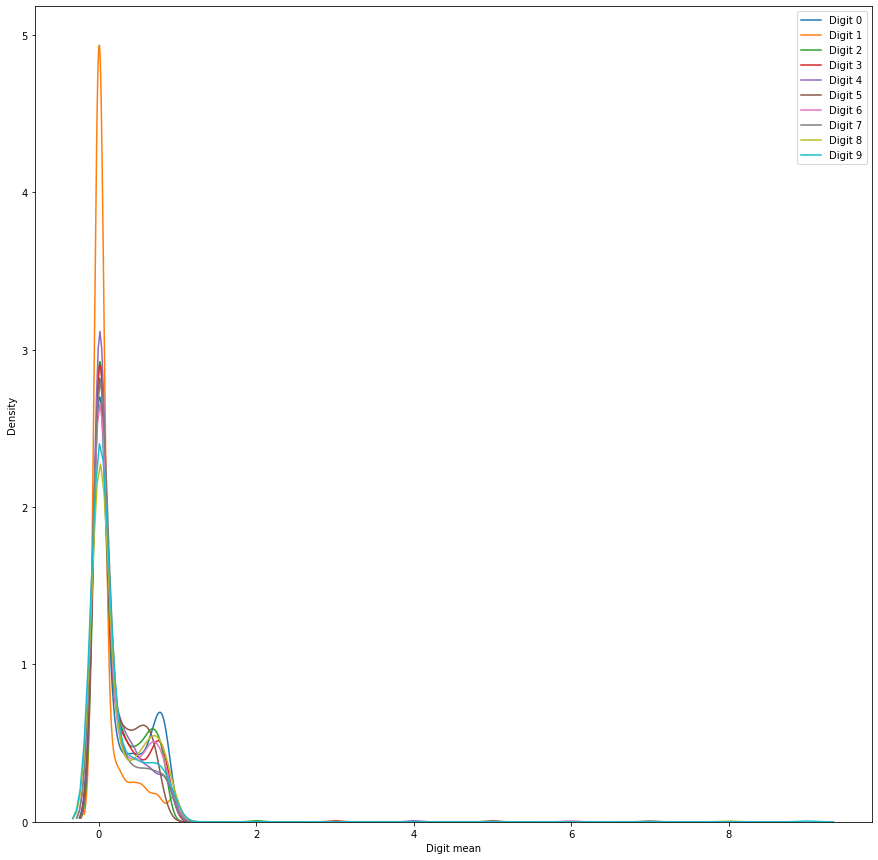

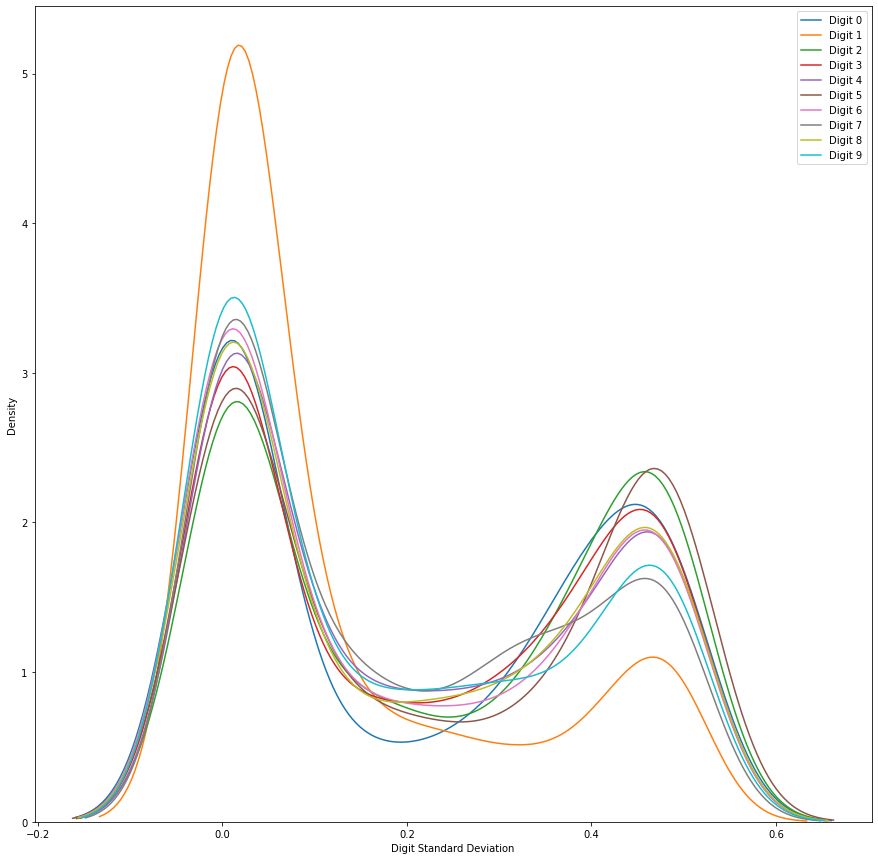

In [ ]:
graph_mean(df)
graph_std(df)

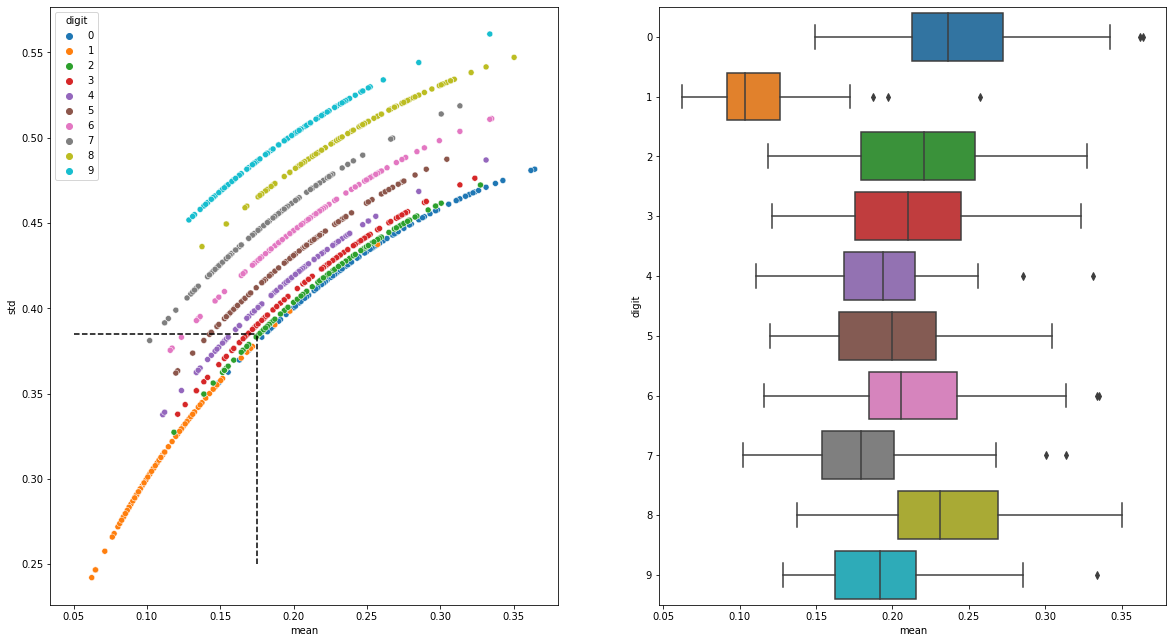

In [ ]:
graph_moment(df, sample_size=100)

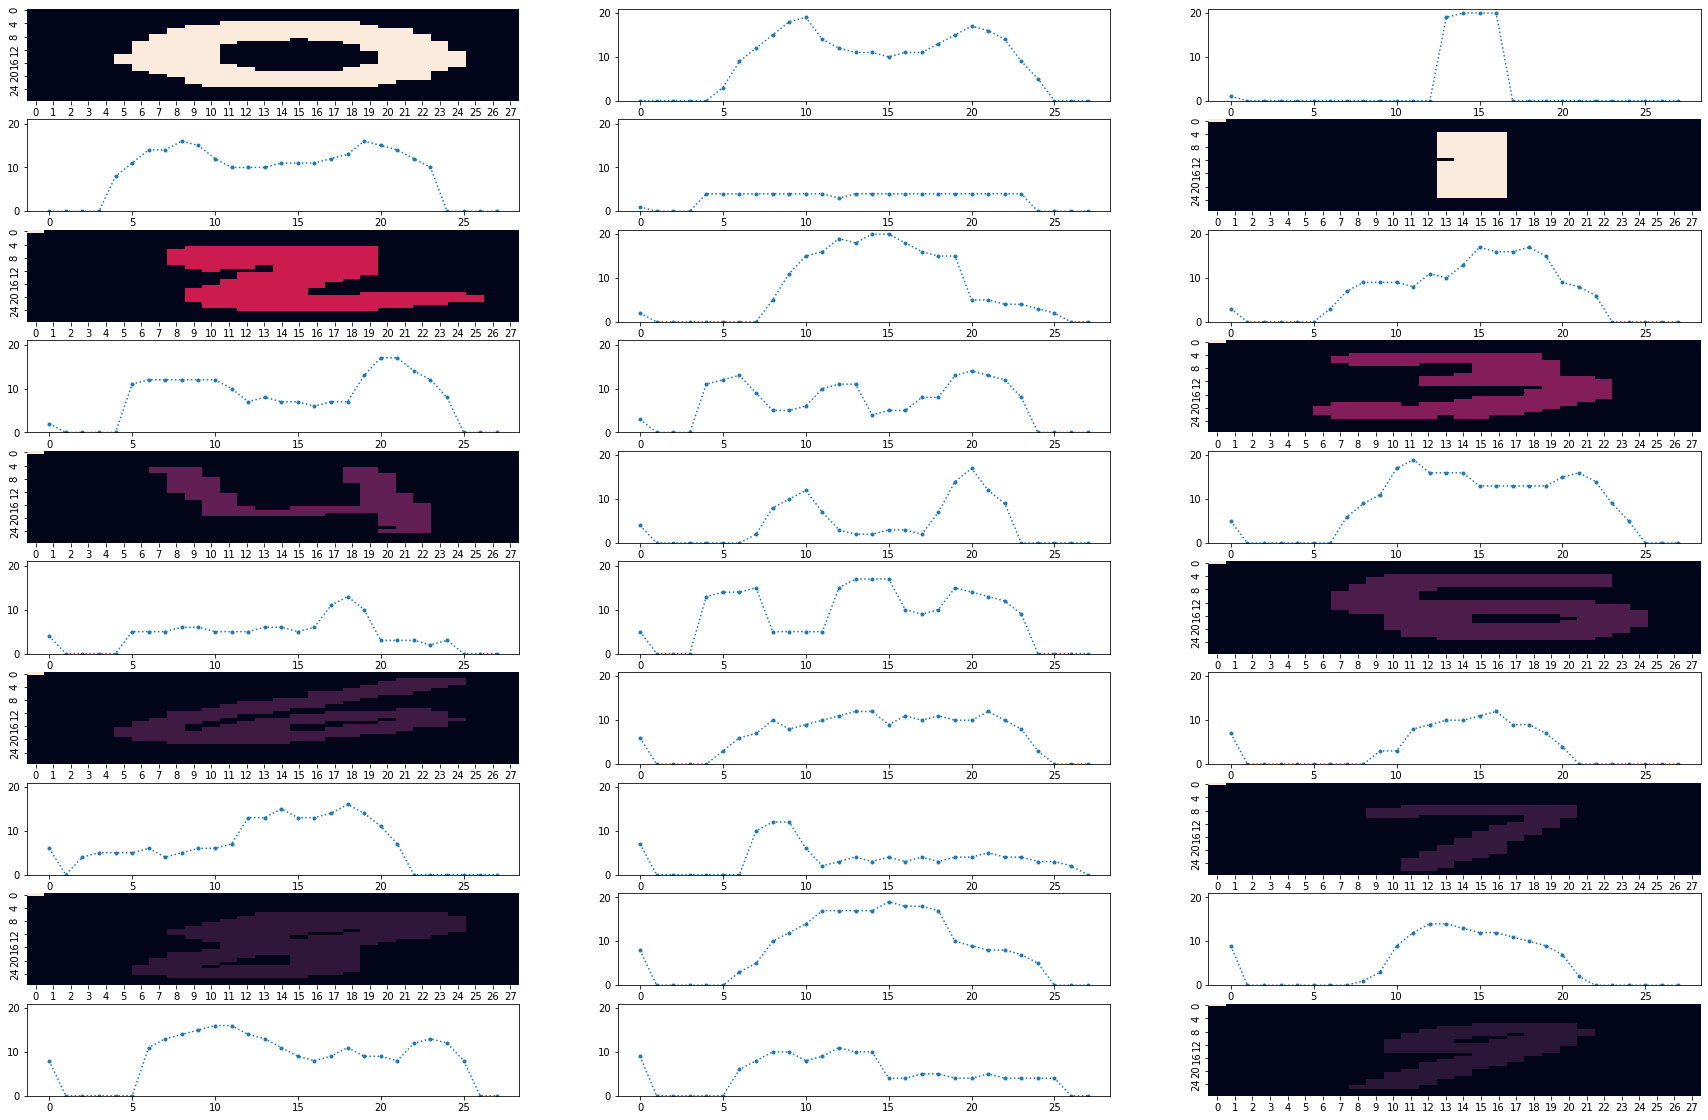

In [ ]:
graph_features(df)

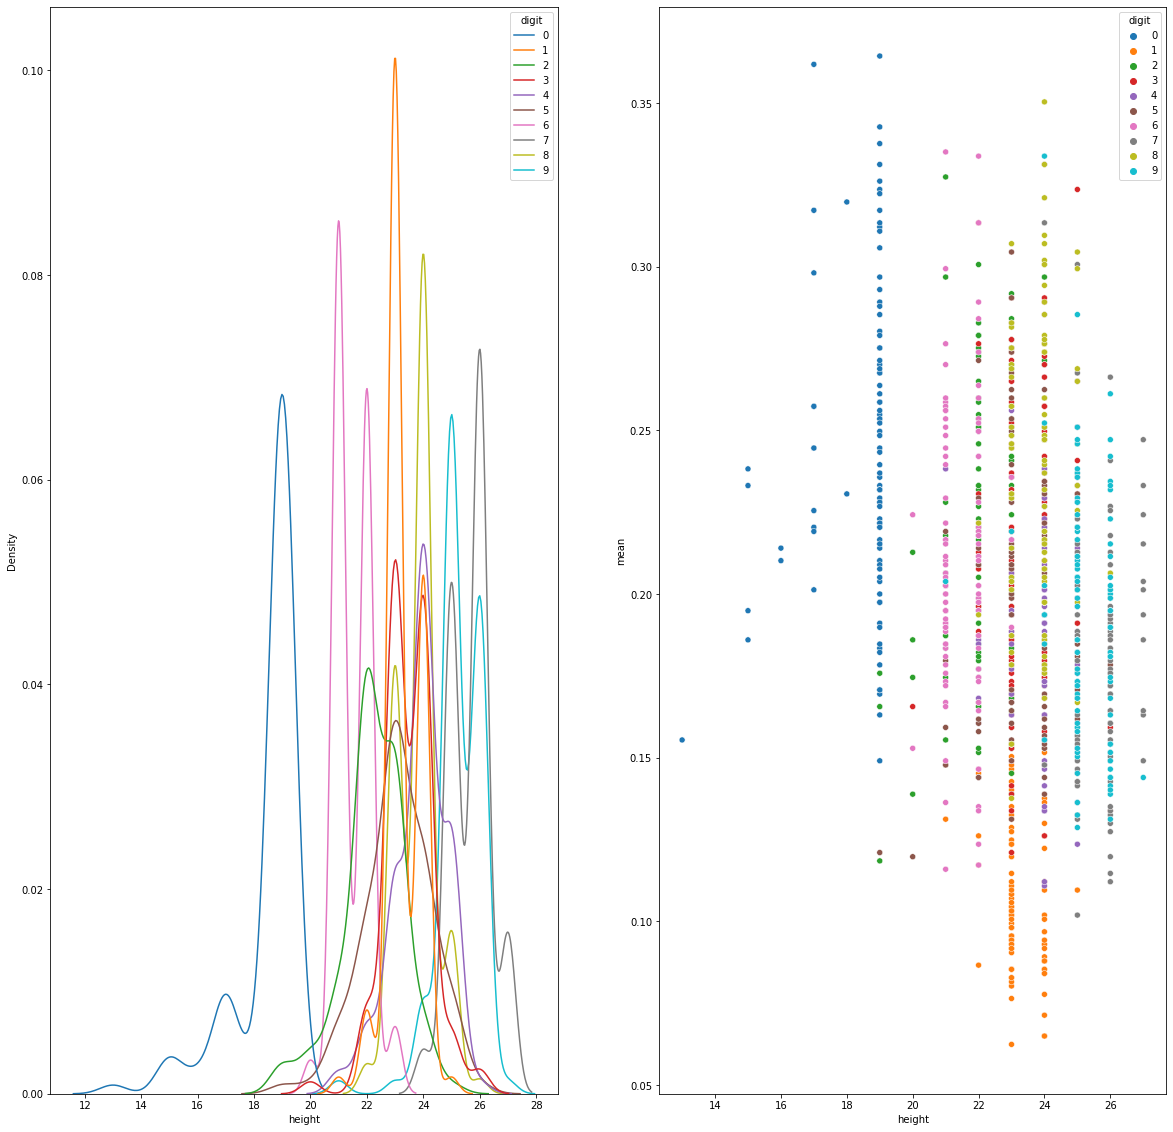

In [ ]:
digit_range = get_digit_range(df)
graph_range(digit_range, to_graph="height")

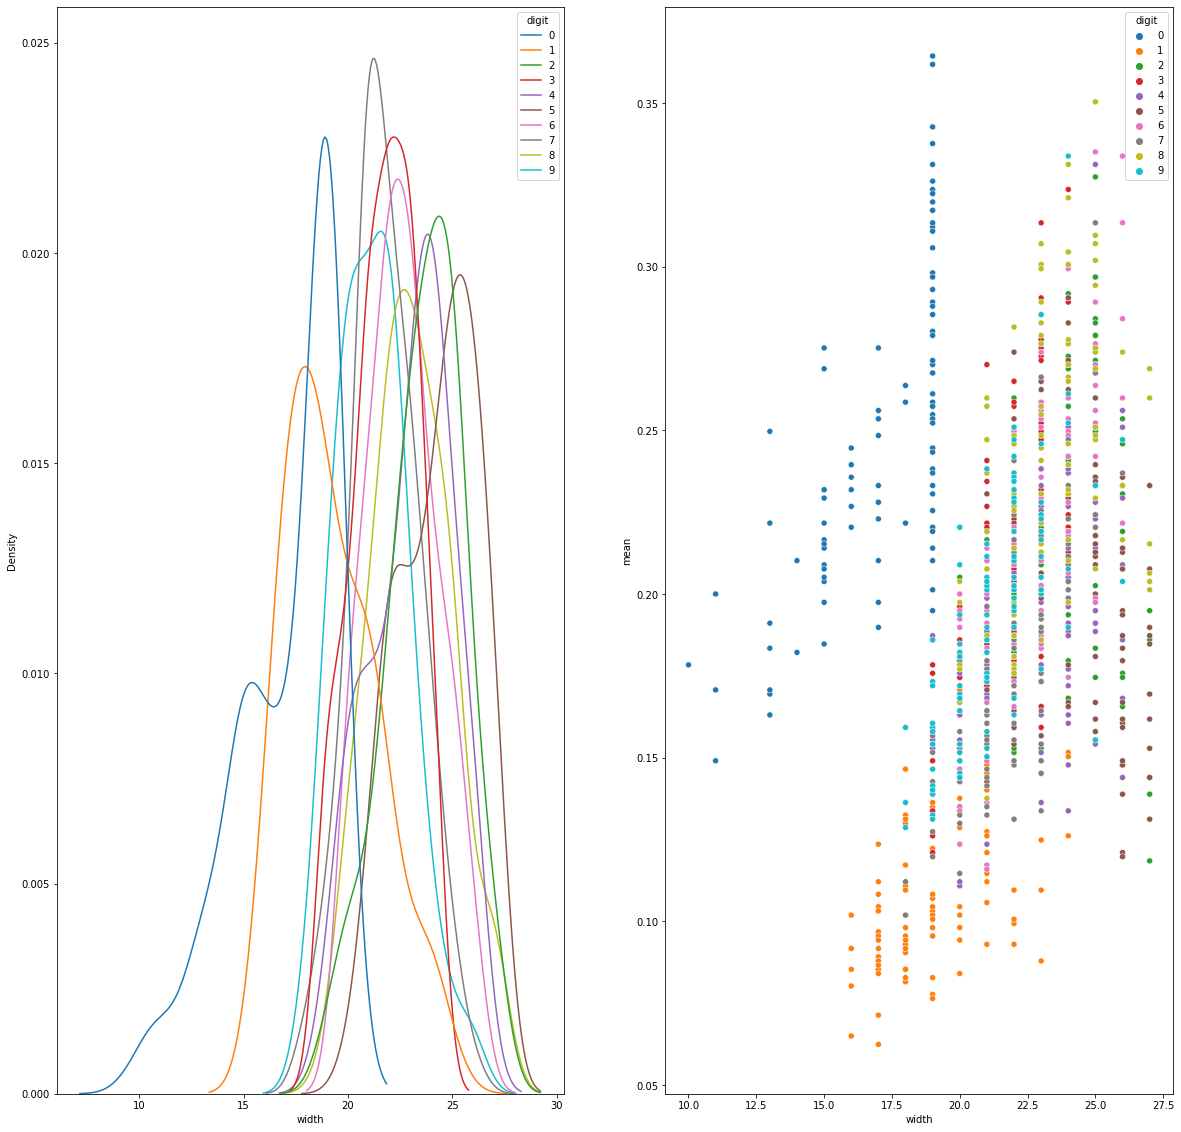

In [ ]:
graph_range(digit_range, to_graph="width")

## 1.4 Final Dataset

Preprocessing the MNIST dataset to work with (width, height, mean, std, and label) can be beneficial for model fitting for several reasons:

* Relevant Features: By extracting the width, height, mean, and standard deviation of each image, you are providing the model with relevant features that can capture important information about the image. The width and height can give information about the size of the image, while the mean and standard deviation can give information about the intensity of the pixels. By providing these features to the model, you can help it to learn better patterns in the data and improve its performance.

* Reduced Dimensionality: By extracting these features, you are reducing the dimensionality of the data. This can be beneficial as it can help to avoid overfitting and speed up the training process.

* Label as a Feature: By including the label as a feature, the model can learn from it, which can be beneficial for classification tasks.

* In the case of MNIST, the dataset contains images of handwritten digits, which can have a range of widths and heights. By extracting these features, the model can learn about the different sizes of the digits and improve its performance. The mean and standard deviation of the image can give information about the intensity of the pixels, which can help the model to differentiate between different digits.

Overall, preprocessing the MNIST dataset to work with (width, height, mean, std, and label) can be beneficial for model fitting by providing relevant features, reducing dimensionality and including the label as a feature that can be used by the model.

In [ ]:
digit_range.head(200)

,width,height,mean,std,28sum_R+28sum_C,digit
1,19,19,0.312102,0.463647,245.0,0
4,19,19,0.331210,0.470949,260.0,0
5,13,19,0.191083,0.393405,150.0,0
17,17,19,0.233121,0.423088,183.0,0
23,19,19,0.313376,0.464161,246.0,0
...,...,...,...,...,...,...
975,18,23,0.131210,0.337845,103.0,1
1000,16,23,0.085350,0.279580,67.0,1
1002,17,23,0.103185,0.304394,81.0,1
1013,22,24,0.109554,0.312532,86.0,1


---
# 2. Scenarios

## First: build $X$ with $Mean$, $std$, $width$, $height$

In [ ]:
# Standard Libraries
import random as rn

# Split test Train Data
from sklearn.model_selection import train_test_split

# Create Pipeline
from sklearn.pipeline import Pipeline

# Grid Search to find best HyperParameter
from sklearn.model_selection import GridSearchCV

# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# StandarScaler
from sklearn.preprocessing import StandardScaler

# Roc Curve
from sklearn.metrics import roc_curve, roc_auc_score
import scikitplot as skplt

# Confusion matrix
from sklearn.metrics import confusion_matrix

# Models to be used
  # Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
  # Regression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
X = digit_range.drop(columns=['28sum_R+28sum_C', 'digit'])
y = digit_range['digit']

In [ ]:
X

,width,height,mean,std
1,19,19,0.312102,0.463647
4,19,19,0.331210,0.470949
5,13,19,0.191083,0.393405
17,17,19,0.233121,0.423088
23,19,19,0.313376,0.464161
...,...,...,...,...
989,21,25,0.152866,0.470638
997,21,26,0.211465,0.508721
1006,19,25,0.160510,0.476188
1028,19,26,0.131210,0.453846


In [ ]:
seed = 1234
np.random.seed(seed)
rn.seed(seed)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
X_train.shape, y_test.shape

((800, 4), (200,))

### Model For each Scenario

#### Classification Models

 * Decision Tree Classifier
 * Random Forest Classifier

In [ ]:
clf = Pipeline([('scl', StandardScaler()), ('classifier', DecisionTreeClassifier(random_state=seed))])

classifier_param_grid = [
    {
      "classifier":[DecisionTreeClassifier(random_state=seed)],
      "classifier__criterion":["gini","entropy"],
      "classifier__max_depth":np.arange(10, 21, 2),
     },
     {
      "classifier":[RandomForestClassifier(random_state=seed)],
      "classifier__criterion":["gini","entropy"],
      "classifier__n_estimators":np.arange(50, 1200, 500),
     }
]

#### Regression Models

* MLP Regressor
* Support Vector Regression

In [ ]:
rgr = Pipeline([('scl', StandardScaler()), ('regression', GradientBoostingRegressor())])

regression_param_grid = [
      {
       "regression": [GradientBoostingRegressor()],
       "regression__learning_rate": [0.01, 0.02, 0.03],
       "regression__subsample"    : [0.9, 0.5,],
       "regression__n_estimators" : [100, 500],
       "regression__max_depth"    : [6, 8, 10]
      },
     {
      "regression": [MLPRegressor(max_iter=1000, random_state=seed)],
      "regression__hidden_layer_sizes": [(10, ), (20, ), (64, )],
      "regression__activation": ['tanh', 'relu'],
      "regression__solver": ['adam', 'sgd', 'lbfgs'],
      "regression__alpha": [0.00005, 0.0005],
     }
]

In [ ]:
clf_grid_search = GridSearchCV(estimator=clf, param_grid=classifier_param_grid, scoring='accuracy', cv=3)
rgr_grid_search = GridSearchCV(estimator=rgr, param_grid=regression_param_grid, n_jobs=-1)

In [ ]:
grids = [clf_grid_search, rgr_grid_search]
for pipe in grids:
    pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Classifiers Test Accuracy: 0.81
Classifiers Best Params: {'classifier': RandomForestClassifier(n_estimators=50, random_state=1234), 'classifier__criterion': 'gini', 'classifier__n_estimators': 50}
    Actual  Prediction
875      6         6.0
943      9         9.0
549      1         2.0
695      7         7.0
402      4         4.0
706      3         1.0
924      6         6.0
587      5         5.0
216      6         6.0
933      0         0.0
609      7         7.0
309      4         4.0
957      8         9.0
819      0         0.0
846      9         9.0
921      4         4.0
251      0         0.0
711      1         3.0
621      4         5.0
292      0         0.0


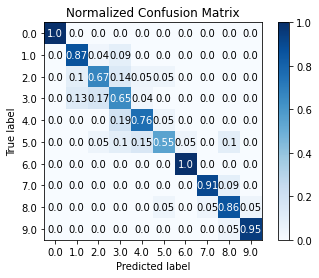

Regressors Test Accuracy: 0.9995473196303414
Regressors Best Params: {'regression': MLPRegressor(activation='tanh', alpha=0.0005, hidden_layer_sizes=(64,),
             max_iter=1000, random_state=1234, solver='lbfgs'), 'regression__activation': 'tanh', 'regression__alpha': 0.0005, 'regression__hidden_layer_sizes': (64,), 'regression__solver': 'lbfgs'}
    Actual  Prediction
875      6         6.0
943      9         9.0
549      1         1.0
695      7         7.0
402      4         4.0
706      3         3.0
924      6         6.0
587      5         5.0
216      6         6.0
933      0         0.0
609      7         7.0
309      4         4.0
957      8         8.0
819      0         0.0
846      9         9.0
921      4         4.0
251      0         0.0
711      1         1.0
621      4         4.0
292      0         0.0


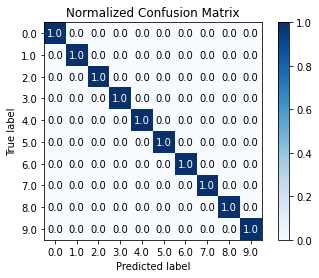

In [ ]:
grid_dict = {0: 'Classifiers', 1: 'Regressors'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],
    model.score(X_test, y_test)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

    # Show Prediction compared to y_test
    predictions = np.clip(np.round(model.predict(X_test).astype(float)), 0, 9)
    prediction_df = pd.DataFrame({ "Actual": y_test, "Prediction": predictions })
    print(prediction_df.head(20))

    #print(confusion_matrix(y_test, predictions))
    skplt.metrics.plot_confusion_matrix(y_test.astype(float), predictions, normalize=True)
    plt.show()

---

## Second: build $X$ with $28Sum_R+ 28Sum_C$

In [ ]:
X2 = digit_range.drop(columns=['width', 'height', 'mean', 'std', 'digit'])
#['28sum_R+28sum_C']
y2 = digit_range['digit']

In [ ]:
X2

,28sum_R+28sum_C
1,245.0
4,260.0
5,150.0
17,183.0
23,246.0
...,...
989,120.0
997,166.0
1006,126.0
1028,103.0


In [ ]:
seed = 1234
np.random.seed(seed)
rn.seed(seed)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=seed)

In [ ]:
X_train.shape, y_test.shape

((800, 1), (200,))

## Model For each Scenario

In [ ]:
# Models to be used
  # Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
  # Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

#### Classification Models

 * KNeighbors Classifier
 * Ada Boost Classifier

In [ ]:
clf = Pipeline([('scl', StandardScaler()), ('classifier', KNeighborsClassifier())])

classifier_param_grid = [
    {
      "classifier":[KNeighborsClassifier()],
      "classifier__n_neighbors": [5, 6, 8],
      "classifier__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
      "classifier__leaf_size": [30, 40, 60],
      "classifier__p": [1, 2],
     },
     {
      "classifier": [AdaBoostClassifier(random_state=seed)],
      "classifier__algorithm": ["SAMME", "SAMME.R"],
      "classifier__learning_rate": [1.0, 0.5, 0.6],
      "classifier__n_estimators": np.arange(50, 1200, 500),
     }
]

#### Regression Models

* Random Forest Regressor
* Logistic Regression

In [ ]:
rgr = Pipeline([('scl', StandardScaler()), ('regression', RandomForestRegressor(random_state=seed))])

regression_param_grid = [
      {
       "regression": [RandomForestRegressor(random_state=seed)],
       "regression__criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
       "regression__n_estimators" : [100, 500],
       "regression__max_depth"    : [6, 8, 10]
      },
     {
      "regression": [LogisticRegression(random_state=seed, max_iter=1000)],
      "regression__C": [1, 0.2],
      "regression__solver": ['sag', 'saga'],
      "regression__penalty": ['l2'],
      "regression__fit_intercept": [True, False],
      "regression__dual": [True, False],
      "regression__tol": [1e-4, 1e-5, 1e-7],
     }
]

In [ ]:
clf_grid_search = GridSearchCV(estimator=clf, param_grid=classifier_param_grid, scoring='accuracy', cv=3, return_train_score=True)
rgr_grid_search = GridSearchCV(estimator=rgr, param_grid=regression_param_grid, n_jobs=-1, return_train_score=True)

In [ ]:
grids = [clf_grid_search, rgr_grid_search]
for pipe in grids:
    pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 354, in fit
    if np.any(y < 0):
TypeError: '<' not supported between instances of 'st

Classifiers Test Accuracy: 0.175
Classifiers Best Params: {'classifier': AdaBoostClassifier(algorithm='SAMME', random_state=1234), 'classifier__algorithm': 'SAMME', 'classifier__learning_rate': 1.0, 'classifier__n_estimators': 50}
    Actual  Prediction
875      6         7.0
943      9         8.0
549      1         7.0
695      7         0.0
402      4         7.0
706      3         1.0
924      6         8.0
587      5         7.0
216      6         7.0
933      0         8.0
609      7         1.0
309      4         7.0
957      8         0.0
819      0         0.0
846      9         8.0
921      4         7.0
251      0         7.0
711      1         7.0
621      4         7.0
292      0         8.0


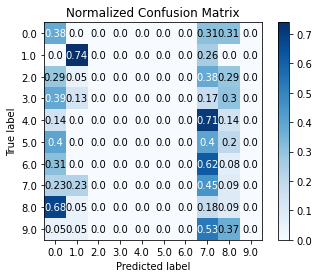

Regressors Test Accuracy: 0.185
Regressors Best Params: {'regression': LogisticRegression(C=1, max_iter=1000, random_state=1234, solver='sag'), 'regression__C': 1, 'regression__dual': False, 'regression__fit_intercept': True, 'regression__penalty': 'l2', 'regression__solver': 'sag', 'regression__tol': 0.0001}
    Actual  Prediction
875      6         9.0
943      9         0.0
549      1         7.0
695      7         6.0
402      4         7.0
706      3         1.0
924      6         0.0
587      5         9.0
216      6         7.0
933      0         0.0
609      7         1.0
309      4         6.0
957      8         0.0
819      0         0.0
846      9         0.0
921      4         6.0
251      0         6.0
711      1         7.0
621      4         7.0
292      0         0.0


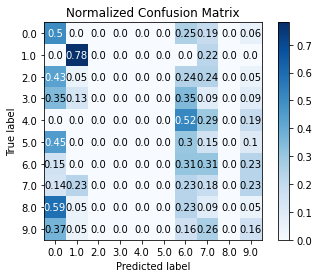

In [ ]:
grid_dict = {0: 'Classifiers', 1: 'Regressors'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],
    model.score(X_test, y_test)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

    # Show Prediction compared to y_test
    predictions = np.clip(np.round(model.predict(X_test).astype(float)), 0, 9)
    prediction_df = pd.DataFrame({ "Actual": y_test, "Prediction": predictions })
    print(prediction_df.head(20))

    #print(confusion_matrix(y_test, predictions))
    skplt.metrics.plot_confusion_matrix(y_test.astype(float), predictions, normalize=True)
    plt.show()

Preprocessing the MNIST dataset to work with (width, height, mean, std, and label) can be beneficial for model fitting instead of only working with a column containing (the sum of rows + the sum of columns and the label) for several reasons:

* More informative features: Using width, height, mean, and standard deviation, instead of the sum of rows and columns, provides the model with more informative features. The width and height can give information about the size of the image, while the mean and standard deviation can give information about the intensity of the pixels. These features can capture important information about the image that can help the model to learn better patterns in the data and improve its performance.

* Better representation of the data: The width, height, mean, and standard deviation can better represent the characteristics of the image and help the model to understand the different variations of the digits. The sum of rows and columns can be too general and not provide enough information about the image.

* Better generalization: Using a set of features that better represent the characteristics of the images can help the model to generalize better and perform better on unseen data.

* In the case of MNIST, the dataset contains images of handwritten digits, which can have a range of widths and heights, and intensity of the pixels. By extracting these features, the model can learn about the different sizes, shapes and intensity of the digits which can improve its performance.

Overall, preprocessing the MNIST dataset to work with (width, height, mean, std, and label) can be beneficial for model fitting by providing more informative features, better representation of the data and better generalization of the model.

---

## Optional Third: build $X$ with using first and second

In [ ]:
X3 = digit_range.drop(columns=['digit'])
y3 = digit_range['digit']

In [ ]:
X3

,width,height,mean,std,28sum_R+28sum_C
1,19,19,0.312102,0.463647,245.0
4,19,19,0.331210,0.470949,260.0
5,13,19,0.191083,0.393405,150.0
17,17,19,0.233121,0.423088,183.0
23,19,19,0.313376,0.464161,246.0
...,...,...,...,...,...
989,21,25,0.152866,0.470638,120.0
997,21,26,0.211465,0.508721,166.0
1006,19,25,0.160510,0.476188,126.0
1028,19,26,0.131210,0.453846,103.0


In [ ]:
seed = 1234
np.random.seed(seed)
rn.seed(seed)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=seed)

In [ ]:
X_train.shape, y_test.shape

((800, 5), (200,))

## Model For each Scenario

#### Classification Models

 * KNeighbors Classifier
 * Ada Boost Classifier

In [ ]:
clf = Pipeline([('scl', StandardScaler()), ('classifier', KNeighborsClassifier())])

classifier_param_grid = [
    {
      "classifier":[KNeighborsClassifier()],
      "classifier__n_neighbors": [5, 6, 8],
      "classifier__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
      "classifier__leaf_size": [30, 40, 60],
      "classifier__p": [1, 2],
     },
     {
      "classifier": [AdaBoostClassifier(random_state=seed)],
      "classifier__algorithm": ["SAMME", "SAMME.R"],
      "classifier__learning_rate": [1.0, 0.5, 0.6],
      "classifier__n_estimators": np.arange(50, 1200, 500),
     }
]

* Random Forest Regressor
* Logistic Regression

In [ ]:
rgr = Pipeline([('scl', StandardScaler()), ('regression', RandomForestRegressor(random_state=seed))])

regression_param_grid = [
      {
       "regression": [RandomForestRegressor(random_state=seed)],
       "regression__criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
       "regression__n_estimators" : [100, 500],
       "regression__max_depth"    : [6, 8, 10]
      },
     {
      "regression": [LogisticRegression(random_state=seed, max_iter=1000)],
      "regression__C": [1, 0.2],
      "regression__solver": ['sag', 'saga'],
      "regression__penalty": ['l2'],
      "regression__fit_intercept": [True, False],
      "regression__dual": [True, False],
      "regression__tol": [1e-4, 1e-5, 1e-7],
     }
]

In [ ]:
clf_grid_search = GridSearchCV(estimator=clf, param_grid=classifier_param_grid, scoring='accuracy', cv=3, return_train_score=True)
rgr_grid_search = GridSearchCV(estimator=rgr, param_grid=regression_param_grid, n_jobs=-1, return_train_score=True)

In [ ]:
grids = [clf_grid_search, rgr_grid_search]
for pipe in grids:
    pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 354, in fit
    if np.any(y < 0):
TypeError: '<' not supported between instances of 'st

Classifiers Test Accuracy: 0.765
Classifiers Best Params: {'classifier': KNeighborsClassifier(), 'classifier__algorithm': 'auto', 'classifier__leaf_size': 30, 'classifier__n_neighbors': 5, 'classifier__p': 2}
    Actual  Prediction
875      6         6.0
943      9         9.0
549      1         3.0
695      7         7.0
402      4         4.0
706      3         1.0
924      6         6.0
587      5         5.0
216      6         6.0
933      0         0.0
609      7         7.0
309      4         3.0
957      8         8.0
819      0         0.0
846      9         9.0
921      4         3.0
251      0         0.0
711      1         2.0
621      4         5.0
292      0         0.0


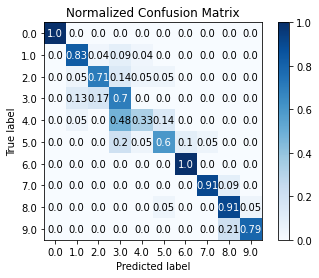

Regressors Test Accuracy: 0.9817295971781895
Regressors Best Params: {'regression': RandomForestRegressor(criterion='friedman_mse', max_depth=10, random_state=1234), 'regression__criterion': 'friedman_mse', 'regression__max_depth': 10, 'regression__n_estimators': 100}
    Actual  Prediction
875      6         6.0
943      9         9.0
549      1         2.0
695      7         7.0
402      4         4.0
706      3         2.0
924      6         6.0
587      5         6.0
216      6         6.0
933      0         0.0
609      7         7.0
309      4         5.0
957      8         8.0
819      0         0.0
846      9         9.0
921      4         5.0
251      0         0.0
711      1         2.0
621      4         4.0
292      0         0.0


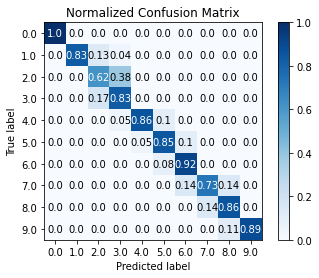

In [ ]:
grid_dict = {0: 'Classifiers', 1: 'Regressors'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],
    model.score(X_test, y_test)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

    # Show Prediction compared to y_test
    predictions = np.clip(np.round(model.predict(X_test).astype(float)), 0, 9)
    prediction_df = pd.DataFrame({ "Actual": y_test, "Prediction": predictions })
    print(prediction_df.head(20))

    #print(confusion_matrix(y_test, predictions))
    skplt.metrics.plot_confusion_matrix(y_test.astype(float), predictions, normalize=True)
    plt.show()

---

# Conclusions

The MLP Regressor is a neural network model, which is known to be a powerful tool for image recognition tasks such as the MNIST dataset. Neural networks are able to learn complex non-linear relationships in the data, which could be important for distinguishing between different handwritten digits.

The MLP Regressor can also handle large amounts of data efficiently, which is important for the MNIST dataset, which contains 60,000 images.

The MLP Regressor has a lot of parameters, that can be fine-tuned, which increases the chances of finding the best set of parameters for a specific dataset.

The other models, such as Decision tree classifier, Random Forest classifier and Random Forest regressor, are based on decision trees, and these models work well for classification problems but not as well for regression problems. Logistic Regression is a simple linear model, it can have lower accuracy when compared to other complex models like MLP.

MLP Regressor was the best fit model for the MNIST dataset with 99% accuracy compared to other models such as Decision tree classifier, Random Forest classifier, Random Forest regressor, Logistic Regression.

* The MLP Regressor used in this experiment had a solver 'lbfgs' which is an optimizer in the family of quasi-Newton methods. lbfgs is a robust optimizer for multi-layer perceptrons and it can handle large datasets efficiently.

* The activation function used was 'tanh' which is a hyperbolic tangent function, it can introduce non-linearity in the model which can help in better modeling complex relationships in the data.

* The alpha parameter is used to control the regularization strength, it can prevent overfitting and help in better generalization of the model, the small value of 0.0005 might have helped in regularizing the model and improved the performance.

* The size of the hidden layers (64,) was used, this is relatively small, but this might have been enough for this dataset and the architecture of the model.

In conclusion, the combination of the above-mentioned parameters might have helped the MLP Regressor to achieve the high accuracy of 99% on the MNIST dataset.